In [ ]:
#!pip install CensusData

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import zipfile
import requests
import pickle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [2]:
# BOOLEAN MASKIBG - CLASS OBJECT
# BM - Boolean Masking
class BM:
    def  __init__(self,df):
        self.df= df
    
    def select( self, column , operator , value):
        if operator ==  "equals":
            return BM(self.df[self.df[column]==value])
        elif operator == "contains":
            return BM(self.df[[(value.lower() in str(title).lower()) for title in self.df[column]]])
        elif operator ==  "gt":
            return BM(self.df[self.df[column] > value])
        elif operator ==  "ge":
            return BM(self.df[self.df[column] >= value])
        elif operator ==  "lt":
            return BM(self.df[self.df[column] <= value])
        elif operator ==  "le":
            return BM(self.df[self.df[column] <= value])

# IMPORT US CENSUS DATA 
Import Census ACS data (download from https://www.census.gov/programs-surveys/acs/data/pums.html )

## SETUP DATA DICTIONARY

### IMPORT GEOCODES

In [3]:
# Read GIPS geocodes for states - run shell command below to import from census.gov
# !curl -O https://www2.census.gov/programs-surveys/popest/geographies/2016/state-geocodes-v2016.xls
fips = pd.read_excel('state-geocodes-v2016.xls')
fips.columns = fips.iloc[4]
fips = fips[5:]

# FIPS-BUNBWERS FOR ALL STATES:
all_state_fips=fips[fips['State (FIPS)'] != '00']['State (FIPS)'].values



# nst() translates fips-numbers to state-names
def nst(fipsnr):
    return fips[fips['State (FIPS)'].apply(int) == int(fipsnr)]['Name'].values[0]
# stn() translates state-names to fips-numbers 
def stn(statename):
    return fips[fips['Name'] == statename]['State (FIPS)'].values[0]



# Test:
#    nst('05'),nst(5)
# Result:
#    ('Arkansas', 'Arkansas')

In [4]:
fips

4,Region,Division,State (FIPS),Name
5,1,0,00,Northeast Region
6,1,1,00,New England Division
7,1,1,09,Connecticut
8,1,1,23,Maine
9,1,1,25,Massachusetts
10,1,1,33,New Hampshire
11,1,1,44,Rhode Island
12,1,1,50,Vermont
13,1,2,00,Middle Atlantic Division
14,1,2,34,New Jersey


###  SETUP PUMS DATA DICTIONARY 
Source: https://www.census.gov/programs-surveys/acs/data/pums.html )

In [4]:
# Read the data dictionary from the CSV imported by getdata.sh
datadic = pd.read_csv("PUMS_Data_Dictionary_2017.csv").drop_duplicates()
datadic.head()

,NAME,RT,C,1,Record Type,Unnamed: 5,Unnamed: 6
0,VAL,RT,C,1,H,H,Housing Record or Group Quarters Unit
1,VAL,RT,C,1,P,P,Person Record
2,NAME,SERIALNO,C,13,Housing unit/GQ person serial number,NaN,NaN
3,VAL,SERIALNO,C,13,2.02E+12,2.02E+12,Unique identifier
4,NAME,DIVISION,C,1,Division code based on 2010 Census definitions,NaN,NaN


In [5]:
# var_defs : definitions of variables 
var_defs = datadic.groupby('RT').first()
var_defs.head()

,NAME,C,1,Record Type,Unnamed: 5,Unnamed: 6
RT,,,,,,
ACCESS,NAME,C,1,Access to the Internet,b,N/A (GQ/vacant)
ACR,NAME,C,1,Lot size,b,N/A (GQ/not a one-family house or mobile home)
ADJHSG,NAME,C,7,Adjustment factor for housing dollar amounts (...,1000000,2017 factor (1.000000)
ADJINC,NAME,C,7,Adjustment factor for income and earnings doll...,1011189,2017 factor (1.011189)
AGEP,NAME,N,2,Age,0,Under 1 year


#### FUNCTIONS FOR NAVIGATING THE DATA DICTIONARY

- var_RT(label) : gets information about a label 
- var_about(word) : gets information about variables including the word in their descriptions (case insensitive)

In [6]:
# All unique variable names
varnames = datadic['RT'].unique()

# All entries for a variable - definition + values 
def var_name(label):
    return BM(datadic).select('RT', 'equals',label).df.drop_duplicates()

# All definitions containing a select string
def var_about(word):
    return pd.concat((BM(datadic).select('Record Type', 'contains',word).df,
                      BM(datadic).select('Unnamed: 6', 'contains',word).df))


#select definitions
def names(df):
    return df[df['NAME']=='NAME']


#select values
def vals(df):
    return df[df['NAME']=='VAL']

Examples:


In [6]:
#  Information about the variable "DEAR"
var_name('DEAR')

,NAME,RT,C,1,Record Type,Unnamed: 5,Unnamed: 6
1308,NAME,DEAR,C,1,Hearing difficulty,NaN,NaN
1309,VAL,DEAR,C,1,1,1,Yes
1310,VAL,DEAR,C,1,2,2,No


In [7]:
#  Information about the variables with "hear"
var_about('hear')

,NAME,RT,C,1,Record Type,Unnamed: 5,Unnamed: 6
1308,NAME,DEAR,C,1,Hearing difficulty,NaN,NaN
5517,NAME,FDEARP,C,1,Hearing difficulty allocation flag,NaN,NaN


In [16]:
# variables about "difficult"
var_about('difficult')

,NAME,RT,C,1,Record Type,Unnamed: 5,Unnamed: 6
1304,NAME,DDRS,C,1,Self-care difficulty,NaN,NaN
1308,NAME,DEAR,C,1,Hearing difficulty,NaN,NaN
1311,NAME,DEYE,C,1,Vision difficulty,NaN,NaN
1314,NAME,DOUT,C,1,Independent living difficulty,NaN,NaN
1318,NAME,DPHY,C,1,Ambulatory difficulty,NaN,NaN
1334,NAME,DREM,C,1,Cognitive difficulty,NaN,NaN
5514,NAME,FDDRSP,C,1,Self-care difficulty allocation flag,NaN,NaN
5517,NAME,FDEARP,C,1,Hearing difficulty allocation flag,NaN,NaN
5520,NAME,FDEYEP,C,1,Vision difficulty allocation flag,NaN,NaN
5526,NAME,FDOUTP,C,1,Independent living difficulty allocation flag,NaN,NaN


### REDUCED VARIABLE SET:  POTENTIALLY RELEVANT VARIABLES (BY ASSUMPTION)

In [7]:
# var_selected : intuitive selection
var_selected=['AGEP','COW','DDRS','DEAR','DEYE','DIS','DOUT','DPHY','DRAT','DRATX','DREM','FOD1P',
              'FOD2P','HICOV','NWLA','NWLK','NWRE','OCCP','OIP','PAP','PERNP','PINCP','POVPIP',
             'POWSP','REGION','RETP','SCHL','SCIENGRLP','SEMP','SOCP','SSIP','SSP','ST','WAGP','WKHP','WKL',
              'WKW','WRK']

var_defs.loc[var_selected]

,NAME,C,1,Record Type,Unnamed: 5,Unnamed: 6
RT,,,,,,
AGEP,NAME,N,2,Age,0,Under 1 year
COW,NAME,C,1,Class of worker,b,N/A (less than 16 years old/NILF who last work...
DDRS,NAME,C,1,Self-care difficulty,b,N/A (Less than 5 years old)
DEAR,NAME,C,1,Hearing difficulty,1,Yes
DEYE,NAME,C,1,Vision difficulty,1,Yes
DIS,NAME,C,1,Disability recode,1,With a disability
DOUT,NAME,C,1,Independent living difficulty,b,N/A (Less than 15 years old)
DPHY,NAME,C,1,Ambulatory difficulty,b,N/A (Less than 5 years old)
DRAT,NAME,C,1,Veteran service connected disability rating (p...,b,N/A (No service-connected disability/never ser...


## CREATE DATASETS FOR ALL STATES: 

In [28]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}



### DOWNLOAD ZIPPED DATA FROM US CENSUS FOR ALL STATES

In [323]:
# Download Data from census for ALL states
# QUIRK: MUST RUN THIS CELL TWICE!
#
# # STEP1. Create the executable shell for downloading all files.
# all_state_zipfiles = ["curl -O https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/"+state_zipfile(fipsnr)+"\n" 
#                       for fipsnr in all_state_fips]
# txt = "".join(all_state_zipfiles)
# f = open("fetch_all_state_zips.sh", "a")
# f.write(txt)
# !chmod +x fetch_all_state_zips.sh
#
#STEP2. FETCH ALL STATE ZIP FILES: 
#Go to commandline prompt and type: 
#  ./fetch_all_state_zips.sh &


###  CREATE DATASETS WITH REDUCED VARIABLE SET

In [10]:
# MINIMUM YEARLY WAGE
minimum_wage = 20000

# MINIMUM HOURS WORKED PER WEEK
minimum_hours = 20

# FULL-TIME : HOURS/WEEK
full_time = 40

#### FUNCTION FOR READING ZIP - REDUCING DATASET - WRITING TO PICKLED FILE ON DISK

In [11]:
# A FUNCTION FOR CREATING A REDUCED DATASET FOR A STATE / FIPS-NUMBER AND SAVE TO DISK AS PICKLED FILE
# QUIRK: FIPS-NUMBER MUST BE ENTERED IN THE FORM OF TWO-CHARACTER STRING, EG "06" 

#FOR NAMING PICKLE: Storage-file-names from fips-number
def state_pklfile(fipsnr):
    state = nst(fipsnr)
    return 'pums_'+state+'.pkl'

# Test:
# state_pklfile(6)
#'pums_California.pkl'


# FUNCTION FOR CREATING REDUCED DATASET AND WRITING TO DISK
def reduced_dataset(fipsnr):
    dfs = pd.DataFrame()
    # READ FULL DATASET FROM ZIP
    with zipfile.ZipFile(state_zipfile(fipsnr)) as z:
        with z.open("psam_p"+fipsnr+".csv") as f:
            dfs = pd.read_csv(f)
    # REMOVE NON-SELECTED VARIABLES
    dfs = dfs[var_selected]
    # REMOVE RECORDS WITHOUT OCCUMPATION CODES
    dfs = dfs.dropna(subset=['OCCP'])
    # REMOVE RECORDS WITH WAGE LESS THAN 20K OR LESS THAN 20 WORK HOURS PER WEEK
    dfs = select(dfs,'WAGP','gt',minimum_wage)
    dfs = select(dfs,'WKHP','gt',minimum_hours)
    dfs['FTE wage'] = dfs['WAGP']*full_time/dfs['WKHP']
    # SAVE PICKLED FILE TO DISK
    dfs.to_pickle(state_pklfile(fipsnr))    
    
# Test:
#     reduced_dataset(all_state_fips[1])
#     !ls *.pkl
# result:
#     pums_Maine.pkl
#
# read the pickle:
#     dfx = pd.read_pickle('pums_Maine.pkl')
#     dfx['FTE wage'][:3]
# result:
#         0    70000.0
#         1    40000.0
#         7    91000.0
#         Name: FTE wage, dtype: float64

### CREATE REDUCED DATASETS FOR ALL STATES

In [12]:
# for fipsnr in all_state_fips:
#     reduced_dataset(fipsnr)

!ls *pkl

deartops.pkl                  pums_Missouri.pkl
deyetops.pkl                  pums_Montana.pkl
pums_Alabama.pkl              pums_Nebraska.pkl
pums_Alaska.pkl               pums_Nevada.pkl
pums_Arizona.pkl              pums_New Hampshire.pkl
pums_Arkansas.pkl             pums_New Jersey.pkl
pums_California.pkl           pums_New Mexico.pkl
pums_Colorado.pkl             pums_New York.pkl
pums_Connecticut.pkl          pums_North Carolina.pkl
pums_Delaware.pkl             pums_North Dakota.pkl
pums_District of Columbia.pkl pums_Ohio.pkl
pums_Florida.pkl              pums_Oklahoma.pkl
pums_Georgia.pkl              pums_Oregon.pkl
pums_Hawaii.pkl               pums_Pennsylvania.pkl
pums_Idaho.pkl                pums_Rhode Island.pkl
pums_Illinois.pkl             pums_South Carolina.pkl
pums_Indiana.pkl              pums_South Dakota.pkl
pums_Iowa.pkl                 pums_Tennessee.pkl
pums_Kansas.pkl               pums_Texas.pkl
pums_Kentucky.pkl             pums_Utah.pkl
pums_Louisiana.pkl

## READ DATA

### DEFINE FUNCTION/CLASS dex(fips_nr) 
**LOADS PICKLED DATAFRAME AS A 'DEX' OBJECT**
- Loads the pickled dataframe for a state (identified by FIPS-number)
- ```DEX```Reduces the dataset according to requirements in the dictionary ```required```
- ```DEX.all``` : the whole population
- ```DEX.dear``` : sub-population with hearing difficulties
- ```DEX.deye``` : sub-population with seeing difficulties


In [8]:
# SOCP - occupation code 
socp = var_name('SOCP').iloc[2:].set_index('Record Type')[['Unnamed: 6']]
socp.loc['111021'].values[0]

required = {}
required['columns'] = ['ST','AGEP','DEAR','DEYE','DIS','FOD1P','FOD2P','SOCP','FTE wage']
required['AGEP'] = {'lower_bound':0,'higher_bound':100}

class DEX:
    def __init__(self,df):
        self.all = BM(df[required['columns']]).select('AGEP','ge',required['AGEP']['lower_bound']).select(
                          'AGEP','le',required['AGEP']['higher_bound']).df
        self.dear = self.all[self.all['DEAR'] == 1]
        self.deye = self.all[self.all['DEYE'] == 1]
    
def median_wage(df, grpby = 'SOCP'):
        df0 = df.copy()
        df0['counter'] = 1
        mdn =df0.groupby(grpby).median()
        mdn['count'] = df0.groupby(grpby).count()['counter']
        return mdn[['count','AGEP','FTE wage']]


def dex(fipsnr):
    return DEX(pd.read_pickle('pums_'+nst(fipsnr)+'.pkl'))
        

### LOAD DATA FOR ALL STATES, AS DEX-OBJECTS

dx = {}
for fipsnr in all_state_fips:
    dx[fipsnr] = dex(fipsnr)

In [9]:
#### SAMPLE SIZES  

# TOTAL POPULATIONS IN SAMPLES
ndear =[] 
ndeye =[]
nall = []

for fipsnr in all_state_fips:
    ndear += [len(dx[fipsnr].dear)]
    ndeye += [len(dx[fipsnr].deye)]
    nall  += [len(dx[fipsnr].all)]
    
print(sum(nall),' : total number of individuals\n',sum(ndear),
      ' : with hearing difficulties\n', sum(ndeye),' : with difficulties seeing')

4907506  : total number of individuals
 94867  : with hearing difficulties
 54192  : with difficulties seeing


In [10]:
dx['06'].all.head(3)

,ST,AGEP,DEAR,DEYE,DIS,FOD1P,FOD2P,SOCP,FTE wage
0,6,21,2,2,2,NaN,NaN,553010,31000.0
1,6,63,2,2,2,6109.0,NaN,291123,336800.0
7,6,22,2,2,1,NaN,NaN,373010,35000.0


# SET POPULATION PARAMETERS / VARIABLES

```dftot``` is the total population according to the selection above

In [61]:
dftot = pd.concat([dx[fipsnr].all for fipsnr in all_state_fips])

### IDENTIFY PREFERRED AGE INTERVAL

Vision and hearing tend to worsen with age for all people. By then, most will already have advanced in their careers. We may assume that the age-dependent hearing/vision difficulties come gradually. 

We seek an age interval where

- People have found their careers: after 30.
- age-related loss of vision and hearing has not yet set in: before 40

#### PREFERRED AGE INTERVAL: 30 - 40.
The plots below indicate that the age interval 30-40 fill the requirements. 



In [65]:
dftot['DEAR'] = dftot['DEAR']== 1
dftot['DEYE'] = dftot['DEYE']== 1
dftot['All'] = 1

aaa = dftot[['AGEP','DEAR','DEYE','All','FTE wage']].groupby('AGEP')
dfage = aaa.sum()[['All','DEAR','DEYE']]
dfage['FTE wage'] = aaa.median()['FTE wage']
dfage['RDEAR'] = dfage['DEAR']/dfage['All']
dfage['RDEYE'] = dfage['DEYE']/dfage['All']

dfage['DEAR FTE wage'] = dftot[dftot['DEAR']==1].groupby('AGEP').median()['FTE wage']
dfage['DEYE FTE wage'] = dftot[dftot['DEYE']==1].groupby('AGEP').median()['FTE wage']

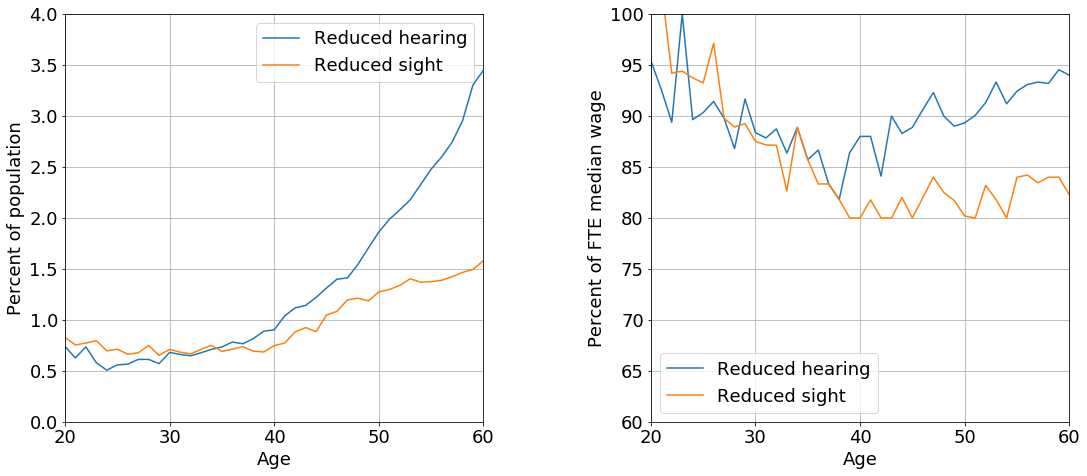

In [73]:
plotdata = dfage

fig = plt.figure()
plt.rcParams.update({'font.size': 18})
fig.set_size_inches(18, 18)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
sns.lineplot(x=plotdata.index, y = 100*plotdata['RDEAR'], label='Reduced hearing',ax=ax)
sns.lineplot(x=plotdata.index, y = 100*plotdata['RDEYE'], label='Reduced sight',ax=ax)
plt.xlim((20,60))
plt.ylim((0,4))
plt.xlabel('Age')
plt.ylabel('Percent of population')
plt.legend()
plt.grid(True)

ax = fig.add_subplot(2, 2, 2)
sns.lineplot(x=plotdata.index, y = 100*plotdata['DEAR FTE wage']/plotdata['FTE wage'], label='Reduced hearing',ax=ax)
sns.lineplot(x=plotdata.index, y = 100*plotdata['DEYE FTE wage']/plotdata['FTE wage'], label='Reduced sight',ax=ax)
plt.xlim((20,60))
plt.ylim((60,100))
plt.xlabel('Age')
plt.ylabel('Percent of FTE median wage')
plt.legend()
plt.grid(True)


# PART 2: ANALYZE OCCUPATIONS

In [74]:
# SOCP - occupation code 
socp = var_name('SOCP').iloc[2:].set_index('Record Type')[['Unnamed: 6']]
socp.loc['111021'].values[0]

'MGR-General And Operations Managers'

In [75]:
medwage={}
medwage['all'] = {}
medwage['dear'] = {}
medwage['deye'] = {}
for fipsnr in all_state_fips:
    medwage["all"][fipsnr]= median_wage(dx[fipsnr].all)

    medwage["dear"][fipsnr]= median_wage(dx[fipsnr].dear)
    medwage['dear'][fipsnr]['FTE relative'] = medwage['dear'][fipsnr]['FTE wage']/medwage['all'][fipsnr]['FTE wage']
    medwage['dear'][fipsnr]['all count'] = medwage['all'][fipsnr]['count']
    medwage['dear'][fipsnr]['relative count'] = medwage['dear'][fipsnr]['count'] / medwage['dear'][fipsnr]['all count']
    medwage['dear'][fipsnr]['count x FTE relative']= medwage['dear'][fipsnr]['count'] * medwage['dear'][fipsnr]['FTE relative']
    medwage['dear'][fipsnr]['count x FTE wage']= medwage['dear'][fipsnr]['count'] * medwage['dear'][fipsnr]['FTE wage']


    
    medwage["deye"][fipsnr]= median_wage(dx[fipsnr].deye)
    medwage['deye'][fipsnr]['FTE relative'] = medwage['deye'][fipsnr]['FTE wage']/medwage['all'][fipsnr]['FTE wage']
    medwage['deye'][fipsnr]['all count'] = medwage['all'][fipsnr]['count']
    medwage['deye'][fipsnr]['relative count'] = medwage['deye'][fipsnr]['count'] / medwage['deye'][fipsnr]['all count']
    medwage['deye'][fipsnr]['count x FTE relative']= medwage['deye'][fipsnr]['count'] * medwage['deye'][fipsnr]['FTE relative']
    medwage['deye'][fipsnr]['count x FTE wage']= medwage['deye'][fipsnr]['count'] * medwage['deye'][fipsnr]['FTE wage']



def mdear(fipsnr):
    return medwage['dear'][fipsnr][['all count','count','count x FTE wage','count x FTE relative']].reset_index()
def mdeye(fipsnr):
    return medwage['deye'][fipsnr][['all count','count','count x FTE wage','count x FTE relative']].reset_index()


In [76]:
us_mdear = pd.concat([mdear(fipsnr) for fipsnr in all_state_fips],axis=0).groupby('SOCP').sum().reset_index()
us_mdear['FTE relative'] = (us_mdear['count x FTE relative'] / us_mdear['count']).round(2)
us_mdear['dear-FTE USmean']  = (us_mdear['count x FTE wage'] / us_mdear['count']).round()
us_mdear['Occupation'] = us_mdear['SOCP'].apply(lambda x:  socp.loc[x][0])
us_mdear= us_mdear[['SOCP','Occupation','FTE relative','dear-FTE USmean','count','all count']]


us_mdeye = pd.concat([mdeye(fipsnr) for fipsnr in all_state_fips],axis=0).groupby('SOCP').sum().reset_index()
us_mdeye['FTE relative'] = (us_mdeye['count x FTE relative'] / us_mdeye['count']).round(2)
us_mdeye['deye-FTE USmean']  = (us_mdeye['count x FTE wage'] / us_mdeye['count']).round()
us_mdeye['Occupation'] = us_mdeye['SOCP'].apply(lambda x:  socp.loc[x][0])
us_mdeye= us_mdeye[['SOCP','Occupation','FTE relative','deye-FTE USmean','count','all count']]



In [77]:
us_mdear.sort_values(['FTE relative'],ascending=False)

,SOCP,Occupation,FTE relative,dear-FTE USmean,count,all count
66,152011,CMM-Actuaries,3.29,323319.0,7,427
214,359031,"EAT-Hosts And Hostesses, Restaurant, Lounge, A...",3.09,98501.0,14,530
437,519191,PRD-Adhesive Bonding Machine Operators And Ten...,2.50,91350.0,10,109
210,353022,"EAT-Counter Attendants, Cafeteria, Food Conces...",2.41,69143.0,6,109
113,231012,LGL-Judicial Law Clerks,2.34,109000.0,2,43
133,272030,ENT-Dancers And Choreographers,1.81,86000.0,1,4
130,272011,ENT-Actors,1.80,89305.0,14,568
228,393031,"PRS-Ushers, Lobby Attendants, And Ticket Takers",1.75,55502.0,6,96
185,319096,HLS-Veterinary Assistants And Laboratory Anima...,1.74,52933.0,18,409
282,434141,OFF-New Accounts Clerks,1.71,62583.0,7,186


In [310]:
us_mdeye.sort_values(['deye-FTE USmean','FTE relative'],ascending=False)

,SOCP,Occupation,FTE relative,deye-FTE USmean,count,all count
74,1720XX,ENG-Biomedical And Agricultural Engineers,4.31,343778.0,2,56
253,434041,"OFF-Credit Authorizers, Checkers, And Clerks",4.45,287955.0,4,54
134,2740XX,ENT-Broadcast And Sound Engineering Technician...,3.38,190184.0,5,407
238,419041,SAL-Telemarketers,3.58,163820.0,4,50
63,152011,CMM-Actuaries,1.21,150000.0,1,24
136,291020,MED-Dentists,1.04,145263.0,11,695
17,119041,MGR-Architectural And Engineering Managers,1.36,140952.0,6,664
140,291060,MED-Physicians And Surgeons,1.11,131005.0,44,8544
88,192099,"SCI-Physical Scientists, All Other",2.22,128878.0,10,1959
174,331012,PRT-First-Line Supervisors Of Police And Detec...,2.14,120670.0,7,277


In [107]:
deartops = us_mdear.sort_values(['dear-FTE USmean','FTE relative'],ascending=False)
deartops['relative count']=deartops['count']/deartops['all count']
deartops[deartops['count']>100].to_pickle('deartops.pkl')

deyetops = us_mdeye.sort_values(['deye-FTE USmean','FTE relative'],ascending=False)
deyetops['relative count']=deyetops['count']/deartops['all count']
deyetops[deyetops['count']>100].to_pickle('deyetops.pkl')

In [109]:
deartops[deartops['count']>100].sort_values('FTE relative',ascending=False)

,SOCP,Occupation,FTE relative,dear-FTE USmean,count,all count,relative count
48,132052,FIN-Personal Financial Advisors,1.28,102740.0,216,14506,0.014890
176,299000,MED-Other Healthcare Practitioners And Technic...,1.26,65226.0,118,4596,0.025674
35,131081,BUS-Logisticians,1.24,60790.0,128,5364,0.023863
207,352021,EAT-Food Preparation Workers,1.24,34782.0,111,6656,0.016677
469,537064,"TRN-Packers And Packagers, Hand",1.21,34742.0,176,7537,0.023351
216,371011,CLN-First-Line Supervisors Of Housekeeping And...,1.19,44414.0,182,6843,0.026597
69,171010,"ENG-Architects, Except Naval",1.19,81644.0,113,7378,0.015316
383,512020,"PRD-Electrical, Electronics, And Electromechan...",1.19,37927.0,108,4345,0.024856
392,513099,"PRD-Food Processing Workers, All Other",1.15,37517.0,117,3928,0.029786
122,253000,EDU-Other Teachers And Instructors,1.14,52644.0,381,18070,0.021085


In [108]:
deyetops[deyetops['count']>100].sort_values('FTE relative',ascending=False)

,SOCP,Occupation,FTE relative,deye-FTE USmean,count,all count,relative count
14,119013,"MGR-Farmers, Ranchers, And Other Agricultural ...",1.12,41967.0,134,12689,0.010088
301,439021,OFF-Data Entry Keyers,1.12,36572.0,162,10478,0.015029
244,412010,SAL-Cashiers,1.12,33554.0,397,25493,0.015401
171,292050,MED-Health Practitioner Support Technologists ...,1.11,38071.0,220,18659,0.011654
466,537061,TRN-Cleaners Of Vehicles And Equipment,1.10,32497.0,107,5336,0.018294
270,433071,OFF-Tellers,1.10,31364.0,106,8515,0.012689
126,259041,EDU-Teacher Assistants,1.09,32971.0,238,16754,0.013980
367,499021,"RPR-Heating, Air Conditioning, And Refrigerati...",1.07,46098.0,190,13344,0.014120
51,132070,FIN-Credit Counselors And Loan Officers,1.07,59362.0,102,11981,0.007875
329,472140,CON-Painters And Paperhangers,1.06,36132.0,144,10446,0.013200
